Title:Examination of the relationship between diet quality, disease status in NHANES participants using a phenome-wide association study (PheWAS) approach

In [7]:
library(hei)
library(ggplot2)
library(dplyr)
library(ggrepel)
library(survey)

Warning message:
“package ‘dplyr’ was built under R version 3.5.1”
Attaching package: ‘dplyr’

The following objects are masked from ‘package:stats’:

    filter, lag

The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union

Warning message:
“package ‘survey’ was built under R version 3.5.2”Loading required package: grid
Loading required package: Matrix
Loading required package: survival

Attaching package: ‘survey’

The following object is masked from ‘package:graphics’:

    dotchart



Import and subset data

In [8]:
nahnes9906 <- load("nh_99-06.Rdata")
Labels <- read.csv("Outcome_Label.csv")
#Subset data (desired survey year coded as '4')
MainTable <- MainTable[ which(MainTable$SDDSRVYR=='4'),]
MainTable_Main<- MainTable[ which(MainTable$RIDAGEYR >= 18),]

#Select disease outcome variables
MainTable_Health <- subset(MainTable_Main, select = c("SEQN", "SDMVPSU", "SDMVSTRA", "WTMEC2YR", 
"RIDAGEYR","BMXBMI", "black", "mexican", "other_hispanic", "other_eth", "SMQ040", "male", 
"female", "any_diabetes", "any_ht", "cad", "bladder_cancer_self_report", "blood_cancer_self_report", 
"bone_cancer_self_report", "brain_cancer_self_report", "breast_cancer_self_report", 
"cervix_cacner_self_report", "colon_cancer_self_report", "esophagus_cancer_self_report", 
"gallbladder_cancer_self_report", "kidney_cancer_self_report", "larynx_cancer_self_report", 
"leukemia_self_report", "liver_cancer_self_report", "lung_cancer_self_report", "lymphoma_self_report", 
"melanoma_self_report", "mouth_cancer_self_report", "nervous_cancer_self_report", 
"ovarian_cancer_self_report", "pancreatic_cancer_self_report", "prostate_cancer_self_report", 
"rectum_cancer_self_report", "skin_cancer_self_report", "other_skin_cancer_self_report", 
"soft_cancer_self_report", "stomach_cancer_self_report", "testis_cancer_self_report", 
"thyroid_cancer_self_report", "uterine_cancer_self_report", "other_cancer_self_report", 
"any_cancer_self_report", "any_family_cad", "current_asthma", "ever_asthma", "ever_arthritis", 
"ever_rheumatoid_arthritis", "ever_osteo_arthritis", "LBXHBC", "LBDHCV", "LBDHD", "LBXHA", "LBDHI"))

#Selecting biomarker variables
Biomarkers_Threshold <- subset(MainTable_Main, select =c("LBXTC", "LBDLDL", "LBXTR", "LBXGH", "LBXGLU", 
"LBXVIA", "LBXVIC", "LBXVID", "LBXVIE",  "LBXB12", "LBXFOL", "LBXRBF", "LBXFER", "LBXHCY"))

#Dichotomize biomarker variables based on cited clinical values
#Total cholesterol - Case <= 200
Biomarkers_Threshold$LBXTC_TH <- ifelse(Biomarkers_Threshold$LBXTC <= 200, 1, 0)
#LDL -  case < 100
Biomarkers_Threshold$LBDLDL_TH <- ifelse(Biomarkers_Threshold$LBDLDL <= 100, 1, 0)
#Triglycerides - case >= 150 
Biomarkers_Threshold$LBXTR_TH <- ifelse(Biomarkers_Threshold$LBXTR <= 150, 1, 0)
#Glycohemoglobin - case <= 5.7 
Biomarkers_Threshold$LBXGH_TH <- ifelse(Biomarkers_Threshold$LBXGH <= 5.7, 1, 0)
#Fasting Glucose -case <= 100
Biomarkers_Threshold$LBXGLU_TH <- ifelse(Biomarkers_Threshold$LBXGLU <= 100, 1, 0)
#Vitamin A - case >= 20 
Biomarkers_Threshold$LBXVIA_TH <- ifelse(Biomarkers_Threshold$LBXVIA >= 20, 1, 0)
#vitamin C - case >= 11.4
Biomarkers_Threshold$LBXVIC_TH <- ifelse(Biomarkers_Threshold$LBXVIC >= 11.4, 1, 0)
#vitamin D - case >= 20
Biomarkers_Threshold$LBXVID_TH <- ifelse(Biomarkers_Threshold$LBXVID >= 20, 1, 0)
#vitamin E - case >= 500
Biomarkers_Threshold$LBXVIE_TH <- ifelse(Biomarkers_Threshold$LBXVIE >= 500, 1, 0)
#vitamin B12 - case  >= 200
Biomarkers_Threshold$LBXB12_TH <- ifelse(Biomarkers_Threshold$LBXB12 >= 200, 1, 0)
#serum folate - case >= 2
Biomarkers_Threshold$LBXFOL_TH <- ifelse(Biomarkers_Threshold$LBXFOL >= 2, 1, 0)
#RBC FOLATE
Biomarkers_Threshold$LBXRBF_TH <- ifelse(Biomarkers_Threshold$LBXRBF >= 95, 1, 0)
#ferritin
Biomarkers_Threshold$LBXFER_TH <- ifelse(Biomarkers_Threshold$LBXFER >= 15, 1, 0)
#plasma homocysteine
Biomarkers_Threshold$LBXHCY_TH <- ifelse(Biomarkers_Threshold$LBXHCY <= 13, 1, 0)

#Subset with only dichotomized values
Biomarkers_Threshold <- subset(Biomarkers_Threshold, select =c("LBXTC_TH", 
"LBDLDL_TH", "LBXTR_TH", "LBXGH_TH", "LBXGLU_TH", "LBXVIA_TH", "LBXVIC_TH", 
"LBXVID_TH", "LBXVIE_TH",  "LBXB12_TH", "LBXFOL_TH", "LBXRBF_TH", "LBXFER_TH", "LBXHCY_TH"))

#Merge biomarker variables with other disease variables
Health_Biomarkers <- cbind(MainTable_Health, Biomarkers_Threshold)

#phenotypes to include in PheWAS
phenotypesheath_biomarkers <- c("any_diabetes", "any_ht", "cad", "bladder_cancer_self_report", 
"blood_cancer_self_report", "bone_cancer_self_report", "brain_cancer_self_report", 
"breast_cancer_self_report", "cervix_cacner_self_report", "colon_cancer_self_report", 
"esophagus_cancer_self_report", "gallbladder_cancer_self_report", "kidney_cancer_self_report", 
"larynx_cancer_self_report", "leukemia_self_report", "liver_cancer_self_report", 
"lung_cancer_self_report", "lymphoma_self_report", "melanoma_self_report", 
"mouth_cancer_self_report", "nervous_cancer_self_report", "ovarian_cancer_self_report", 
"pancreatic_cancer_self_report", "prostate_cancer_self_report", "rectum_cancer_self_report", 
"skin_cancer_self_report", "other_skin_cancer_self_report", "soft_cancer_self_report", 
"stomach_cancer_self_report", "testis_cancer_self_report", "thyroid_cancer_self_report", 
"uterine_cancer_self_report", "other_cancer_self_report", "any_cancer_self_report", 
"any_family_cad", "current_asthma", "ever_asthma", "ever_arthritis", "ever_rheumatoid_arthritis", 
"ever_osteo_arthritis", "LBXHBC", "LBDHCV", "LBDHD", "LBXHA", "LBDHI", "LBXTC_TH", "LBDLDL_TH", 
"LBXTR_TH", "LBXGH_TH", "LBXGLU_TH", "LBXVIA_TH", "LBXVIC_TH", "LBXVID_TH", "LBXVIE_TH",  
"LBXB12_TH", "LBXFOL_TH", "LBXRBF_TH", "LBXFER_TH", "LBXHCY_TH")

Now we use the hei R library to derive healthy eating index scores for individuals in subset of data

In [9]:
demo0506 <- get_demo("2005/2006")             #demographic variables for 2005/2006 survey
diet0506 <- get_diet("2005/2006", "both")     #get dietary variablesfor 2005/2006 survey
fped0506 <- get_fped("2005/2006", "both")     #get nutrient equivalent for 2005/2006 survey
hei0506 <- hei(fped0506, diet0506, demo0506)  #get HEI scores for NHANES
hei0506 <- subset(hei0506, select = c(SEQN,HEI))   #subset so we have SEQN and HEI variables only
hei0506 <- hei0506 %>% mutate(quintile=ntile(HEI,5))  #make quintile column to derive quintiles of HEI

Processing SAS dataset DEMO_D 	 ..
Processing SAS dataset DR1TOT_D 	 ..
Processing SAS dataset DR2TOT_D 	 ..


Setting dataframe, cut, case, control and phenotype variables values - Can edit code if different dataframes, cuts or case control values desired to alternative analyses

In [10]:
dataframe <- Health_Biomarkers
cut <- "quintile"
case <- 5   #cases are those in the top quintile of HEI
control <- 1  #controls are those in the bottom quintile of HEI
phenotypes <- phenotypesheath_biomarkers

Merging quintile values to working data frame

In [11]:
hei0506_subset <- subset(hei0506, select = c("SEQN", cut))   #subset with cut (quintile) and SEQN
hei0506_subset$SEQN <- as.character( hei0506_subset$SEQN )    #change both 'SEQN' columns to characters for merging
dataframe$SEQN <- as.character( dataframe$SEQN )
hei0506_merged <- merge(dataframe, hei0506_subset, by="SEQN")     #merging the quintile values to main dataframe

Selecting cases and controls so that our subset consists of those in the top & bottom quintiles of the healthy eating index

In [12]:
#selecting cases & control
hei0506_merged_cut <- hei0506_merged[hei0506_merged[,cut] %in% c(case, control),]   
#subsetting so we just have SEQN+cut 
hei0506_casecontrol <- subset(hei0506_merged_cut, select=c("SEQN", cut))
#Converting case control to binary (if case)
hei0506_casecontrol[cut] <- ifelse(hei0506_casecontrol[cut]==case, 1, 0) 
#Merge phenotypes w/ binary 
hei0506_final <- inner_join(hei0506_merged, hei0506_casecontrol, by = "SEQN")  

#Changing names of columns. 'casevalue' contains 1s and 0s while 'casecontrol contains 5s and 1s
colNumber <- length(hei0506_final) - 1
colnames(hei0506_final)[colNumber] <- "casecontrol"
colNumber <- length(hei0506_final)
colnames(hei0506_final)[colNumber] <- "casevalue"

Using svy package, setting survey design





In [13]:
dsn <- svydesign(ids=~SDMVPSU, strata=~SDMVSTRA, weights=~WTMEC2YR, nest=T, 
                 data=hei0506_final, variables = NULL)

Create empty dataframe that we will use for loop to populate with results

In [14]:
hei0506_result <- as.data.frame(matrix(ncol =8))

For loop to run logistic regressions on all disease outcomes

In [15]:
for(i in 14:ncol(hei0506_final)-2){      #disease variables start at column 14 
  print( i )
  #glm using survey-weighted glm
  myglm <- svyglm(as.formula(paste0(names(hei0506_final)[i], "~ casevalue + 
                                                              female + 
                                                              black + 
                                                              mexican + 
                                                              other_hispanic + 
                                                              other_eth + 
                                                              BMXBMI+SMQ040 + 
                                                              RIDAGEYR + 
                                                              RIDAGEYR^2")),
                  design = dsn,
                  family = binomial(),
                  na.action = na.omit)
  
  #confidence interval
  ci <- exp(summary(myglm)$coefficients["casevalue",1]+qnorm(c(0.025, 0.975)) * summary(myglm)$coefficients["casevalue",2])
  
  
  excludedPatients <- sum(is.na(hei0506_final[, i ]))
  casecontrol <-  hei0506_final[, c(names(hei0506_final)[i], "SEQN", "casevalue")]
  casecontrol <- na.omit( casecontrol )
  heihighpositive <- length(unique(casecontrol[casecontrol[,1]== 1 & casecontrol$casevalue== 1, "SEQN"]))
  heihighnegative <- length(unique(casecontrol[casecontrol[,1]== 0 & casecontrol$casevalue== 1, "SEQN"]))
  heilowpositive <- length(unique(casecontrol[casecontrol[,1]== 1 & casecontrol$casevalue== 0, "SEQN"]))
  heilownegative <- length(unique(casecontrol[casecontrol[,1]== 0 & casecontrol$casevalue== 0, "SEQN"]))
  
  #New row contains all results for a logistic each logistic regression
  newRow <- c (names(hei0506_final)[i], summary(myglm)$coefficients[2], exp(summary(myglm)$coefficients[2]), paste0("(", round(ci[1][1],3), ",", round(ci[2][1],3), ")"),
               summary(myglm)$coefficients[2,4], paste0(heihighpositive+heilowpositive,"(",heihighpositive,"/",heilowpositive,")"), paste0(heihighnegative+heilownegative,"(",heihighnegative,"/",heilownegative,")"), excludedPatients
  )
  #merge new row to result dataframe
  hei0506_result <- rbind( newRow, hei0506_result ) 
}

[1] 12


Warning message in eval(family$initialize):
“non-integer #successes in a binomial glm!”Warning message:
“glm.fit: algorithm did not converge”

[1] 13


Warning message in model.matrix.default(mt, mf, contrasts):
“the response appeared on the right-hand side and was dropped”Warning message in model.matrix.default(mt, mf, contrasts):
“problem with term 2 in model.matrix: no columns are assigned”Warning message in eval(family$initialize):
“non-integer #successes in a binomial glm!”Warning message in model.matrix.default(glm.object, data = structure(list(female = c(0, :
“the response appeared on the right-hand side and was dropped”Warning message in model.matrix.default(glm.object, data = structure(list(female = c(0, :
“problem with term 2 in model.matrix: no columns are assigned”

[1] 14


Warning message in eval(family$initialize):
“non-integer #successes in a binomial glm!”

[1] 15


Warning message in eval(family$initialize):
“non-integer #successes in a binomial glm!”

[1] 16


Warning message in eval(family$initialize):
“non-integer #successes in a binomial glm!”

[1] 17


Warning message in eval(family$initialize):
“non-integer #successes in a binomial glm!”Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”

[1] 18


Warning message in eval(family$initialize):
“non-integer #successes in a binomial glm!”Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”

[1] 19


Warning message:
“glm.fit: algorithm did not converge”

[1] 20


Warning message:
“glm.fit: algorithm did not converge”

[1] 21


Warning message in eval(family$initialize):
“non-integer #successes in a binomial glm!”Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”

[1] 22


Warning message in eval(family$initialize):
“non-integer #successes in a binomial glm!”Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”

[1] 23


Warning message in eval(family$initialize):
“non-integer #successes in a binomial glm!”

[1] 24


Warning message:
“glm.fit: algorithm did not converge”

[1] 25


Warning message:
“glm.fit: algorithm did not converge”

[1] 26


Warning message in eval(family$initialize):
“non-integer #successes in a binomial glm!”Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”

[1] 27


Warning message in eval(family$initialize):
“non-integer #successes in a binomial glm!”Warning message:
“glm.fit: algorithm did not converge”Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”

[1] 28


Warning message:
“glm.fit: algorithm did not converge”

[1] 29


Warning message:
“glm.fit: algorithm did not converge”

[1] 30


Warning message in eval(family$initialize):
“non-integer #successes in a binomial glm!”Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”

[1] 31


Warning message in eval(family$initialize):
“non-integer #successes in a binomial glm!”Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”

[1] 32


Warning message in eval(family$initialize):
“non-integer #successes in a binomial glm!”

[1] 33


Warning message in eval(family$initialize):
“non-integer #successes in a binomial glm!”Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”

[1] 34


Warning message:
“glm.fit: algorithm did not converge”

[1] 35


Warning message:
“glm.fit: algorithm did not converge”

[1] 36


Warning message:
“glm.fit: algorithm did not converge”

[1] 37


Warning message in eval(family$initialize):
“non-integer #successes in a binomial glm!”Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”

[1] 38


Warning message in eval(family$initialize):
“non-integer #successes in a binomial glm!”Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”

[1] 39


Warning message in eval(family$initialize):
“non-integer #successes in a binomial glm!”

[1] 40


Warning message in eval(family$initialize):
“non-integer #successes in a binomial glm!”

[1] 41


Warning message:
“glm.fit: algorithm did not converge”

[1] 42


Warning message in eval(family$initialize):
“non-integer #successes in a binomial glm!”Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”

[1] 43


Warning message in eval(family$initialize):
“non-integer #successes in a binomial glm!”Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”

[1] 44


Warning message:
“glm.fit: algorithm did not converge”

[1] 45


Warning message in eval(family$initialize):
“non-integer #successes in a binomial glm!”Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”

[1] 46


Warning message in eval(family$initialize):
“non-integer #successes in a binomial glm!”

[1] 47


Warning message in eval(family$initialize):
“non-integer #successes in a binomial glm!”

[1] 48


Warning message in eval(family$initialize):
“non-integer #successes in a binomial glm!”

[1] 49


Warning message in eval(family$initialize):
“non-integer #successes in a binomial glm!”

[1] 50


Warning message in eval(family$initialize):
“non-integer #successes in a binomial glm!”

[1] 51


Warning message in eval(family$initialize):
“non-integer #successes in a binomial glm!”

[1] 52


Warning message in eval(family$initialize):
“non-integer #successes in a binomial glm!”

[1] 53


Warning message in eval(family$initialize):
“non-integer #successes in a binomial glm!”

[1] 54


Warning message in eval(family$initialize):
“non-integer #successes in a binomial glm!”

[1] 55


Warning message in eval(family$initialize):
“non-integer #successes in a binomial glm!”

[1] 56


Warning message:
“glm.fit: algorithm did not converge”

[1] 57


Warning message in eval(family$initialize):
“non-integer #successes in a binomial glm!”

[1] 58


Warning message in eval(family$initialize):
“non-integer #successes in a binomial glm!”

[1] 59


Warning message in eval(family$initialize):
“non-integer #successes in a binomial glm!”

[1] 60


Warning message in eval(family$initialize):
“non-integer #successes in a binomial glm!”

[1] 61


Warning message in eval(family$initialize):
“non-integer #successes in a binomial glm!”

[1] 62


Warning message in eval(family$initialize):
“non-integer #successes in a binomial glm!”

[1] 63


Warning message in eval(family$initialize):
“non-integer #successes in a binomial glm!”

[1] 64


Warning message in eval(family$initialize):
“non-integer #successes in a binomial glm!”Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”

[1] 65


Warning message:
“glm.fit: algorithm did not converge”

[1] 66


Warning message in eval(family$initialize):
“non-integer #successes in a binomial glm!”

[1] 67


Warning message in eval(family$initialize):
“non-integer #successes in a binomial glm!”Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”

[1] 68


Warning message in eval(family$initialize):
“non-integer #successes in a binomial glm!”

[1] 69


Warning message in eval(family$initialize):
“non-integer #successes in a binomial glm!”Warning message:
“glm.fit: algorithm did not converge”

[1] 70


Warning message in eval(family$initialize):
“non-integer #successes in a binomial glm!”Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”

[1] 71


Warning message in eval(family$initialize):
“non-integer #successes in a binomial glm!”

[1] 72


Warning message in eval(family$initialize):
“non-integer #successes in a binomial glm!”

Changing columns names, and adding columns 

In [16]:
#Change column names of results table
colnames( hei0506_result) <- c("Outcome", "Coefficient", "OR", 
                               "CI", "P-value", "Outcome_Present", "Outcome_Negative", "NA_Patient")

#add columns for fdr and bonferroni adjusted p-values
hei0506_result$padjustFdr <- p.adjust( as.numeric( hei0506_result$`P-value`), method = "fdr")
hei0506_result$padjustBonferroni <- p.adjust( as.numeric( hei0506_result$`P-value`), method = "bonferroni")

#add columns for log transformed adjusted p-values
hei0506_result$logfdr <- -log( as.numeric(hei0506_result$padjustFdr))
hei0506_result$logbonf <- -log( as.numeric(hei0506_result$padjustBonferroni))

#Merge Outcome_Label csv to result dataframe
hei0506_result <- merge(hei0506_result, Labels, by = "Outcome")

#add column 'Association' for Odds Ratio > 1 or <=1 to use in Manhatten Plot
hei0506_result$Association <- as.factor(ifelse(hei0506_result$OR > 1, "OR > 1", "OR <= 1"))

Create Manhatten plot using ggplot

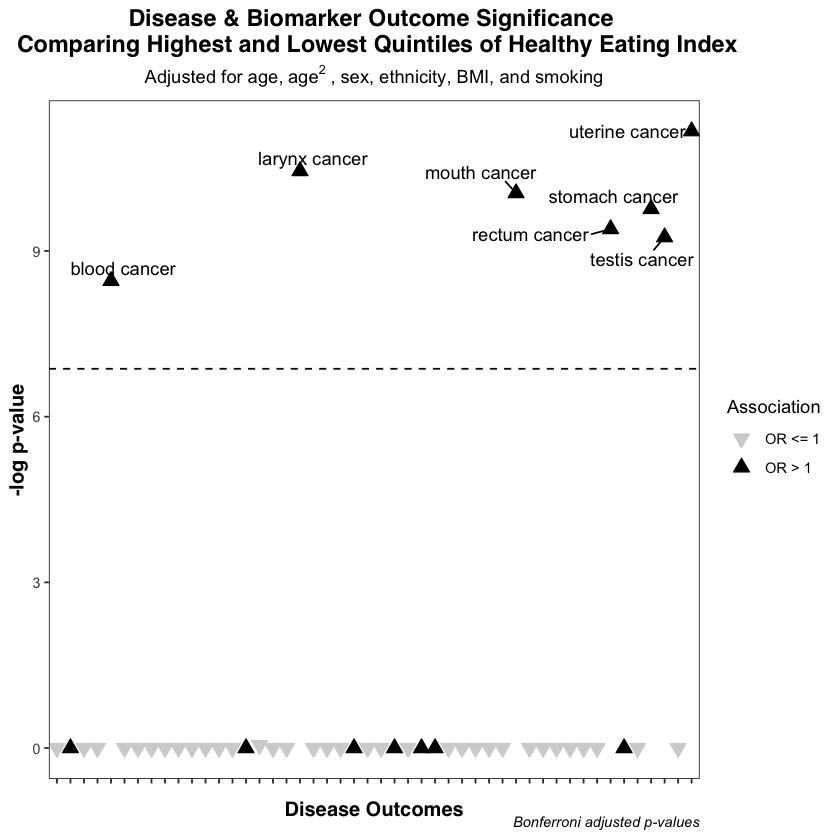

In [17]:
ggplot(hei0506_result, aes(Outcome, logbonf))+     #X values are the Outcome (disease) amd Y is log(p-value)
  geom_point(aes(color = Association, fill = Association, shape = Association), size=3)+
  scale_shape_manual(values=c(25, 24))+
  scale_fill_manual(values=c("lightgray","black"))+
  scale_color_manual(values = c("lightgray", "black"))+
  geom_text_repel(data = subset(hei0506_result, logbonf > -log(0.05/nrow(hei0506_result)) ),aes(label=Label))+
  geom_hline(yintercept= (-log(0.05/nrow(hei0506_result))), linetype="dashed", color = "black")+
  labs(title ="Disease & Biomarker Outcome Significance \n Comparing Highest and Lowest Quintiles of Healthy Eating Index",
       subtitle = bquote("Adjusted for age,"~ age^2~", sex, ethnicity, BMI, and smoking"),
       caption = "Bonferroni adjusted p-values")+
  ylab("-log p-value")+
  xlab("Disease Outcomes")+
  #ggtitle("Disease & Biomarker Outcome Significance \n Comparing Highest and Lowest Quintiles of Healthy Eating Index")+
  theme_bw()+
  theme(axis.text.x = element_blank(), 
        panel.grid.major = element_blank(), 
        panel.grid.minor = element_blank(), 
        plot.subtitle = element_text(face = "italic", hjust = 0.5),
        plot.caption = element_text(face = "italic", hjust = 1),
        axis.title.x = element_text(family="Helvetica", face = "bold", size = 12, vjust = -2),
        axis.title.y = element_text(family="Helvetica", face = "bold", size = 12),
        plot.title=element_text(family = "Helvetica", face = "bold", size = 14, hjust=0.5))